# Imports

In [1]:
!pip install -q autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.8/234.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 428.0/428.0 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor, TabularDataset
from autogluon.core.metrics import f1, accuracy, roc_auc

# Load the Data

In [4]:
# Load the Beijing PM2.5 dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'
df = pd.read_csv(url)

# Display basic information about the dataset
print(f"Data shape: {df.shape}")
print(f"Data columns: {df.columns.tolist()}")
display(df.head())

Data shape: (43824, 13)
Data columns: ['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


# Prepare the Data

In [5]:
# Display missing values count before imputation
print("Missing values before imputation:")
print(df.isnull().sum())

Missing values before imputation:
No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64


In [6]:
# Impute missing values for categorical columns with the most frequent value
for col in df.select_dtypes(include='category').columns:
    most_frequent = df[col].mode()[0]
    df[col].fillna(most_frequent, inplace=True)

# Impute missing values for numeric columns with the median value
for col in df.select_dtypes(include='number').columns:
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)

# Convert categorical columns to 'category' dtype
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

In [7]:
# Display missing values count after imputation
print("Missing values after imputation:")
print(df.isnull().sum())

# Display the cleaned data
print(f"\nData after cleaning: {df.shape}")
display(df.head())

Missing values after imputation:
No       0
year     0
month    0
day      0
hour     0
pm2.5    0
DEWP     0
TEMP     0
PRES     0
cbwd     0
Iws      0
Is       0
Ir       0
dtype: int64

Data after cleaning: (43824, 13)


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,72.0,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,72.0,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,72.0,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,72.0,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,72.0,-20,-12.0,1018.0,NW,12.97,0,0


In [8]:
# Combine year, month, day, and hour into a single datetime column
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Set the datetime column as the index
df.set_index('datetime', inplace=True)

# Drop the original 'No' column and other date-related columns if no longer needed
df.drop(columns=['No', 'year', 'month', 'day', 'hour'], inplace=True)

# Display the data with the datetime index
print("Data with datetime index:")
display(df.head())

Data with datetime index:


,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
datetime,,,,,,,,
2010-01-01 00:00:00,72.0,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,72.0,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,72.0,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,72.0,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,72.0,-20,-12.0,1018.0,NW,12.97,0,0


Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
First few rows:


,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
datetime,,,,,,,,
2010-01-01 00:00:00,72.0,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,72.0,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,72.0,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,72.0,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,72.0,-20,-12.0,1018.0,NW,12.97,0,0



Time Series Plot:


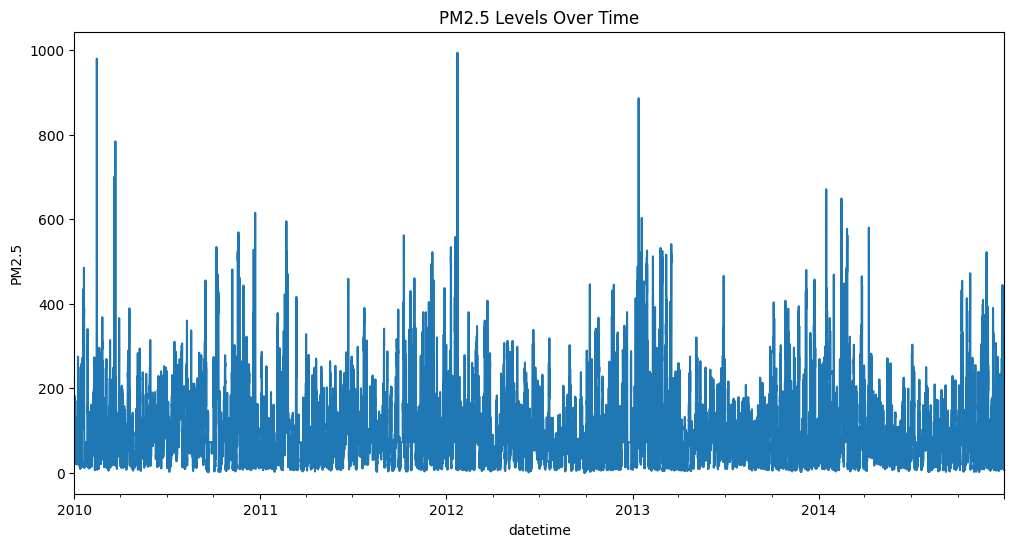

In [9]:
# Check the data index and first few rows
print("Index type:", type(df.index))
print("First few rows:")
display(df.head())

# Plot a time series of PM2.5 levels to visually inspect
print("\nTime Series Plot:")
df['pm2.5'].plot(figsize=(12, 6), title="PM2.5 Levels Over Time")
plt.ylabel("PM2.5")
plt.show()

In [10]:
# Data shape before lagging
print(f"Data shape before lagging: {df.shape}")

# Create lag features for pm2.5
for lag in range(1, 4):  # Create 3 lag features
    df[f'pm2.5_lag{lag}'] = df['pm2.5'].shift(lag)

# Drop rows with NaN values caused by lagging
df.dropna(inplace=True)

# Data shape after lagging
print(f"Data shape after lagging: {df.shape}")

Data shape before lagging: (43824, 8)
Data shape after lagging: (43821, 11)


In [11]:
# Create rolling mean and standard deviation features for pm2.5
df['pm2.5_rolling_mean'] = df['pm2.5'].rolling(window=3).mean()
df['pm2.5_rolling_std'] = df['pm2.5'].rolling(window=3).std()

# Drop rows with NaN values caused by rolling operations
df.dropna(inplace=True)

In [12]:
# Encode categorical variable 'cbwd'
df = pd.get_dummies(df, columns=['cbwd'], drop_first=True)

# Display the dataframe after feature engineering
print("Data after feature engineering:")
display(df.head())

Data after feature engineering:


,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,pm2.5_lag1,pm2.5_lag2,pm2.5_lag3,pm2.5_rolling_mean,pm2.5_rolling_std,cbwd_NW,cbwd_SE,cbwd_cv
datetime,,,,,,,,,,,,,,,
2010-01-01 05:00:00,72.0,-19,-10.0,1017.0,16.10,0,0,72.0,72.0,72.0,72.0,0.0,True,False,False
2010-01-01 06:00:00,72.0,-19,-9.0,1017.0,19.23,0,0,72.0,72.0,72.0,72.0,0.0,True,False,False
2010-01-01 07:00:00,72.0,-19,-9.0,1017.0,21.02,0,0,72.0,72.0,72.0,72.0,0.0,True,False,False
2010-01-01 08:00:00,72.0,-19,-9.0,1017.0,24.15,0,0,72.0,72.0,72.0,72.0,0.0,True,False,False
2010-01-01 09:00:00,72.0,-20,-8.0,1017.0,27.28,0,0,72.0,72.0,72.0,72.0,0.0,True,False,False


In [13]:
# Perform a temporal train-test split
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Verify the split
print(f"Training data range: {train_data.index.min()} to {train_data.index.max()}")
print(f"Testing data range: {test_data.index.min()} to {test_data.index.max()}")

Training data range: 2010-01-01 05:00:00 to 2013-12-31 19:00:00
Testing data range: 2013-12-31 20:00:00 to 2014-12-31 23:00:00


# Regression

In [14]:
# Define the label for regression
regression_label = 'pm2.5'

# Initialize and train the predictor for forecasting
predictor = TabularPredictor(label=regression_label, problem_type='regression').fit(train_data)

# Predict and evaluate on the test set
regression_predictions = predictor.predict(test_data)
regression_performance = predictor.evaluate(test_data)

print("\nRegression Performance Metrics:")
display(regression_performance)

No path specified. Models will be saved in: "AutogluonModels/ag-20240829_220754"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          8
Memory Avail:       49.27 GB / 50.99 GB (96.6%)
Disk Space Avail:   183.52 GB / 225.83 GB (81.3%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : 

[1000]	valid_set's rmse: 12.784
[2000]	valid_set's rmse: 11.3367
[3000]	valid_set's rmse: 10.6862
[4000]	valid_set's rmse: 10.2581
[5000]	valid_set's rmse: 9.96592
[6000]	valid_set's rmse: 9.75113
[7000]	valid_set's rmse: 9.63859
[8000]	valid_set's rmse: 9.57181
[9000]	valid_set's rmse: 9.4617
[10000]	valid_set's rmse: 9.38486


	-9.3837	 = Validation score   (-root_mean_squared_error)
	21.26s	 = Training   runtime
	0.89s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 7.32437
[2000]	valid_set's rmse: 6.87065
[3000]	valid_set's rmse: 6.77067
[4000]	valid_set's rmse: 6.71482
[5000]	valid_set's rmse: 6.69515
[6000]	valid_set's rmse: 6.69957
[7000]	valid_set's rmse: 6.69316
[8000]	valid_set's rmse: 6.69737


	-6.6909	 = Validation score   (-root_mean_squared_error)
	10.54s	 = Training   runtime
	0.5s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-9.9297	 = Validation score   (-root_mean_squared_error)
	13.99s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: CatBoost ...
	-9.0631	 = Validation score   (-root_mean_squared_error)
	22.7s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-9.4812	 = Validation score   (-root_mean_squared_error)
	5.77s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-1.7259	 = Validation score   (-root_mean_squared_error)
	37.62s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost ...
	-10.23	 = Validation score   (-root_mean_squared_error)
	0.84s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-20.0371	 = Validation score   (-root_mean_squared_error)
	24.98s	 = Training   runtime
	0.03s	 = Validation ru

[1000]	valid_set's rmse: 9.80124
[2000]	valid_set's rmse: 9.76585


	-9.765	 = Validation score   (-root_mean_squared_error)
	8.34s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	Ensemble Weights: {'NeuralNetFastAI': 0.895, 'LightGBM': 0.053, 'CatBoost': 0.053}
	-1.5109	 = Validation score   (-root_mean_squared_error)
	0.02s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 154.55s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 4564.7 rows/s (2500 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20240829_220754")



Regression Performance Metrics:


{'root_mean_squared_error': -1.5858669030160923,
 'mean_squared_error': -2.5149738340818524,
 'mean_absolute_error': -1.0054109990732794,
 'r2': 0.999709399378977,
 'pearsonr': 0.9999454735480342,
 'median_absolute_error': -0.5058403015136719}

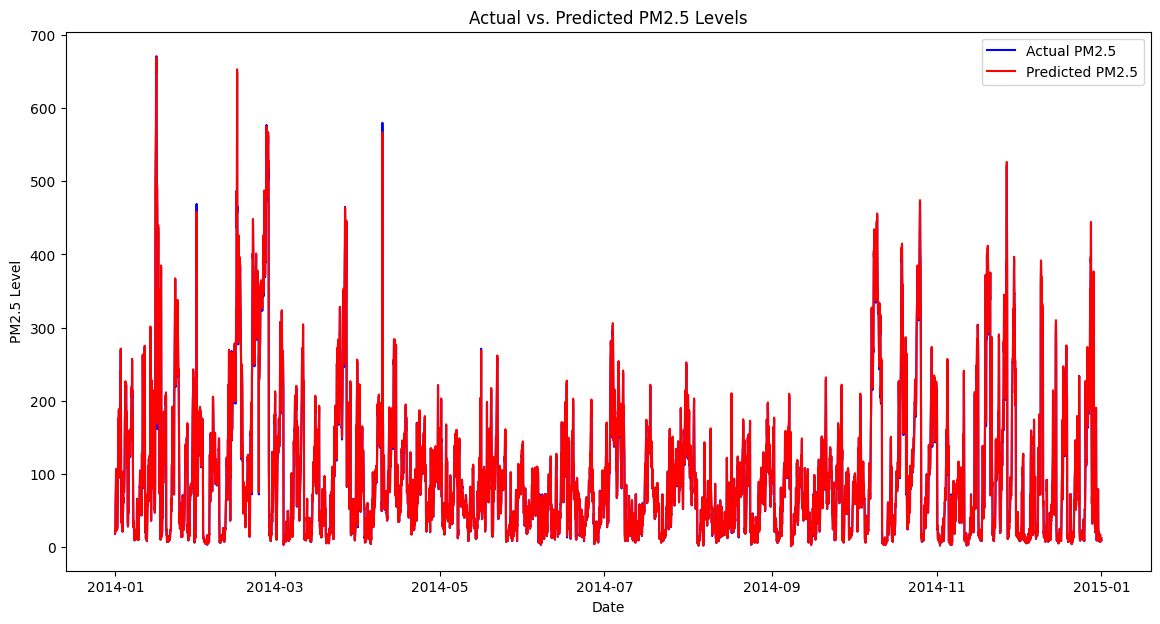

In [15]:
# Plot actual vs. predicted PM2.5 levels
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data['pm2.5'], label='Actual PM2.5', color='blue')
plt.plot(test_data.index, regression_predictions, label='Predicted PM2.5', color='red')
plt.title('Actual vs. Predicted PM2.5 Levels')
plt.xlabel('Date')
plt.ylabel('PM2.5 Level')
plt.legend()
plt.show()

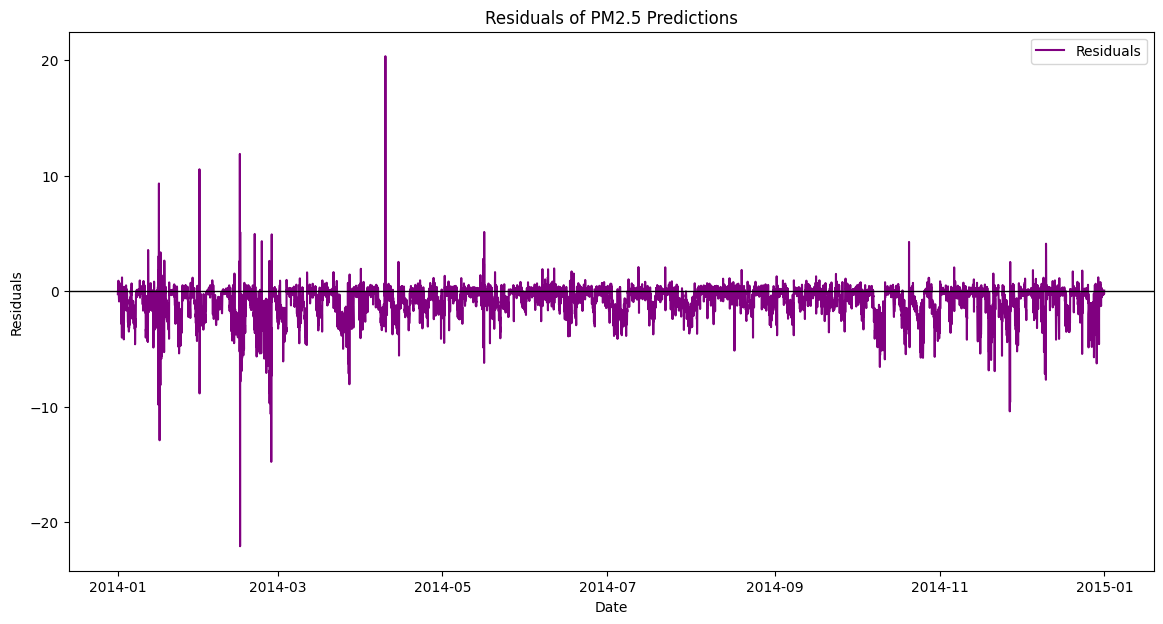

In [16]:
# Compute residuals
residuals = test_data['pm2.5'] - regression_predictions

# Plot residuals
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, residuals, label='Residuals', color='purple')
plt.axhline(0, color='black', linewidth=1)
plt.title('Residuals of PM2.5 Predictions')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Classification

In [17]:
# Define a threshold for high pollution
threshold = 75
df['high_pollution'] = (df['pm2.5'] > threshold).astype(int)

# Split the data again to include the new label
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Initialize and train the predictor for classification
classification_label = 'high_pollution'
predictor_class = TabularPredictor(label=classification_label, problem_type='binary').fit(train_data)

# Predict and evaluate on the test set
classification_predictions = predictor_class.predict(test_data)
classification_performance = predictor_class.evaluate(test_data)

print("\nClassification Performance Metrics:")
display(classification_performance)

No path specified. Models will be saved in: "AutogluonModels/ag-20240829_221033"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          8
Memory Avail:       48.03 GB / 50.99 GB (94.2%)
Disk Space Avail:   182.32 GB / 225.83 GB (80.7%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : 


Classification Performance Metrics:


{'accuracy': 1.0,
 'balanced_accuracy': 1.0,
 'mcc': 1.0,
 'roc_auc': 1.0,
 'f1': 1.0,
 'precision': 1.0,
 'recall': 1.0}

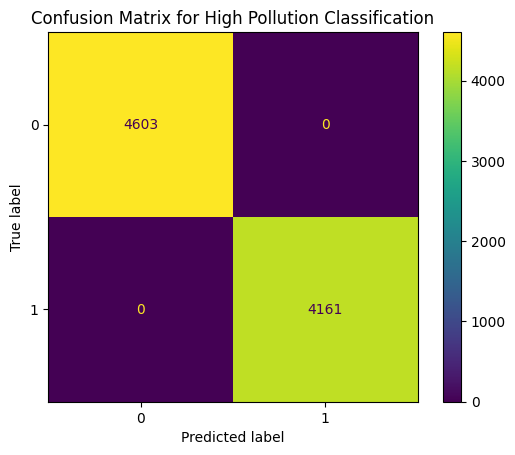

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

# Generate and plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(test_data['high_pollution'], classification_predictions)
plt.title('Confusion Matrix for High Pollution Classification')
plt.show()

In [19]:
# Check the shape and type of the output from predict_proba()
proba_output = predictor_class.predict_proba(test_data)
print("Shape of predict_proba output:", proba_output.shape)
print("Type of predict_proba output:", type(proba_output))

Shape of predict_proba output: (8764, 2)
Type of predict_proba output: <class 'pandas.core.frame.DataFrame'>


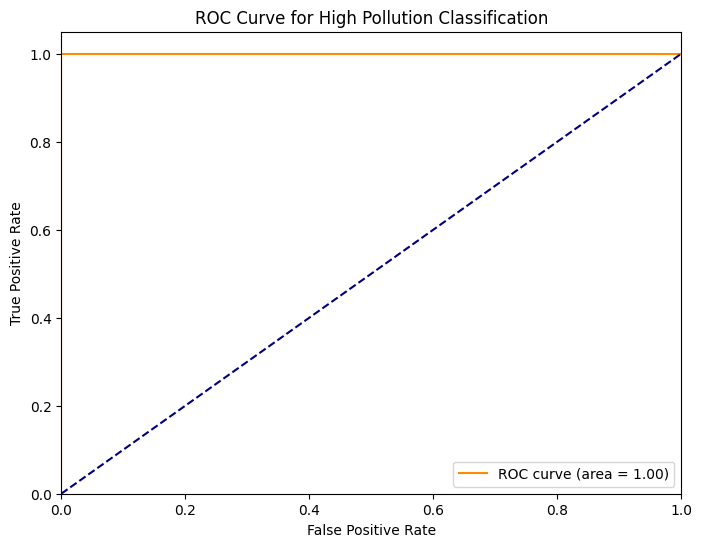

In [20]:
from sklearn.metrics import roc_curve, auc

# Extract the probabilities for the positive class
positive_class_proba = predictor_class.predict_proba(test_data).iloc[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_data['high_pollution'], positive_class_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for High Pollution Classification')
plt.legend(loc="lower right")
plt.show()

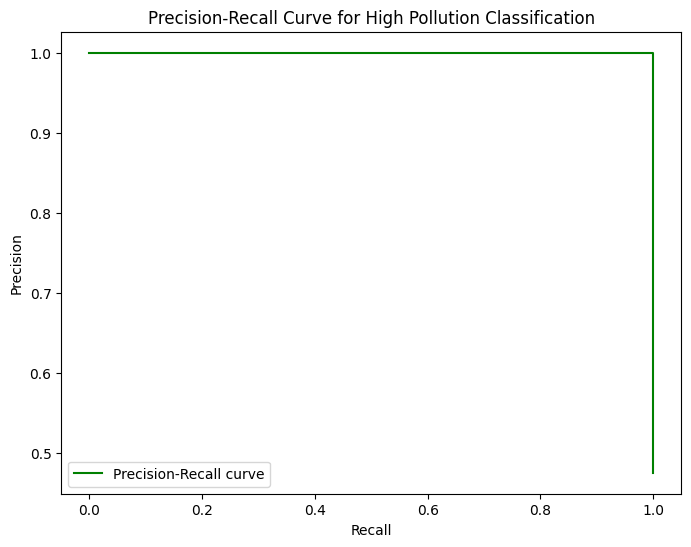

In [21]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(test_data['high_pollution'], positive_class_proba)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for High Pollution Classification')
plt.legend(loc="lower left")
plt.show()

# Feature Importance

In [22]:
# Identify feature importance
regression_feature_importance = predictor.feature_importance(test_data)

# Display feature importance
print("\nFeature Importance:")
display(regression_feature_importance)

These features in provided data are not utilized by the predictor and will be ignored: ['high_pollution']
Computing feature importance via permutation shuffling for 14 features using 5000 rows with 5 shuffle sets...
	91.48s	= Expected runtime (18.3s per shuffle set)
	82.98s	= Actual runtime (Completed 5 of 5 shuffle sets)



Feature Importance:


,importance,stddev,p_value,n,p99_high,p99_low
pm2.5_rolling_mean,287.319024,5.388096,1.483411e-08,5,298.413188,276.224859
pm2.5_lag2,95.801024,1.045526,1.702048e-09,5,97.953777,93.648271
pm2.5_lag1,88.649416,0.890468,1.221498e-09,5,90.482902,86.815930
pm2.5_rolling_std,0.328103,0.045692,4.398954e-05,5,0.422183,0.234023
cbwd_NW,0.006722,0.009461,9.366075e-02,5,0.026202,-0.012758
DEWP,0.005412,0.017231,2.605878e-01,5,0.040892,-0.030067
PRES,0.003919,0.035184,4.077859e-01,5,0.076363,-0.068525
cbwd_SE,0.001530,0.006865,3.222500e-01,5,0.015666,-0.012606
Is,0.000597,0.000233,2.294267e-03,5,0.001077,0.000117
cbwd_cv,-0.000038,0.000684,5.463890e-01,5,0.001370,-0.001446


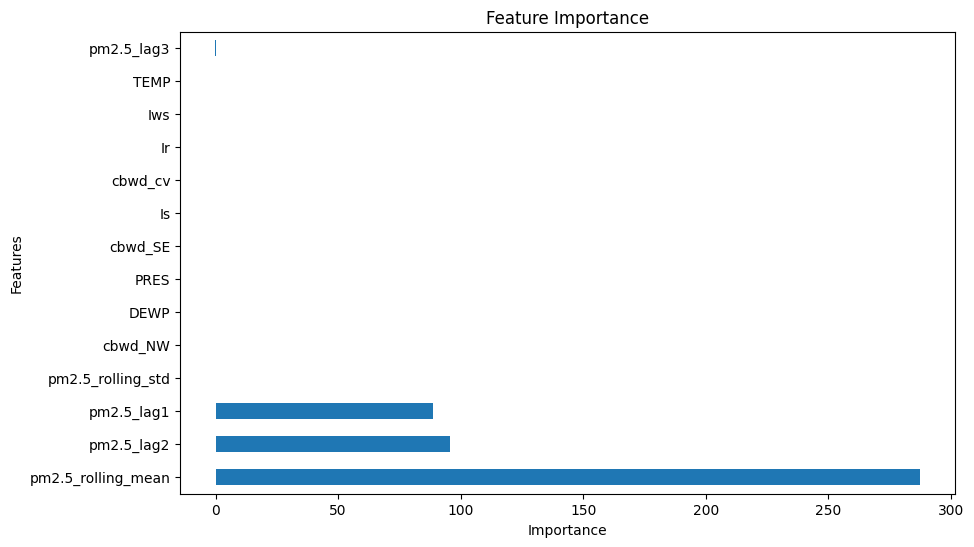

In [23]:
# Plot feature importance
regression_feature_importance[['importance']].plot(kind='barh', figsize=(10, 6), legend=False)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [24]:
# Identify feature importance
classification_feature_importance = predictor_class.feature_importance(test_data)

# Display feature importance
print("\nFeature Importance:")
display(classification_feature_importance)

Computing feature importance via permutation shuffling for 15 features using 5000 rows with 5 shuffle sets...
	1.31s	= Expected runtime (0.26s per shuffle set)
	0.57s	= Actual runtime (Completed 5 of 5 shuffle sets)



Feature Importance:


,importance,stddev,p_value,n,p99_high,p99_low
pm2.5,0.5004,0.010341,2.187485e-08,5,0.521693,0.479107
DEWP,0.0000,0.000000,5.000000e-01,5,0.000000,0.000000
TEMP,0.0000,0.000000,5.000000e-01,5,0.000000,0.000000
PRES,0.0000,0.000000,5.000000e-01,5,0.000000,0.000000
Iws,0.0000,0.000000,5.000000e-01,5,0.000000,0.000000
Is,0.0000,0.000000,5.000000e-01,5,0.000000,0.000000
Ir,0.0000,0.000000,5.000000e-01,5,0.000000,0.000000
pm2.5_lag1,0.0000,0.000000,5.000000e-01,5,0.000000,0.000000
pm2.5_lag2,0.0000,0.000000,5.000000e-01,5,0.000000,0.000000
pm2.5_lag3,0.0000,0.000000,5.000000e-01,5,0.000000,0.000000


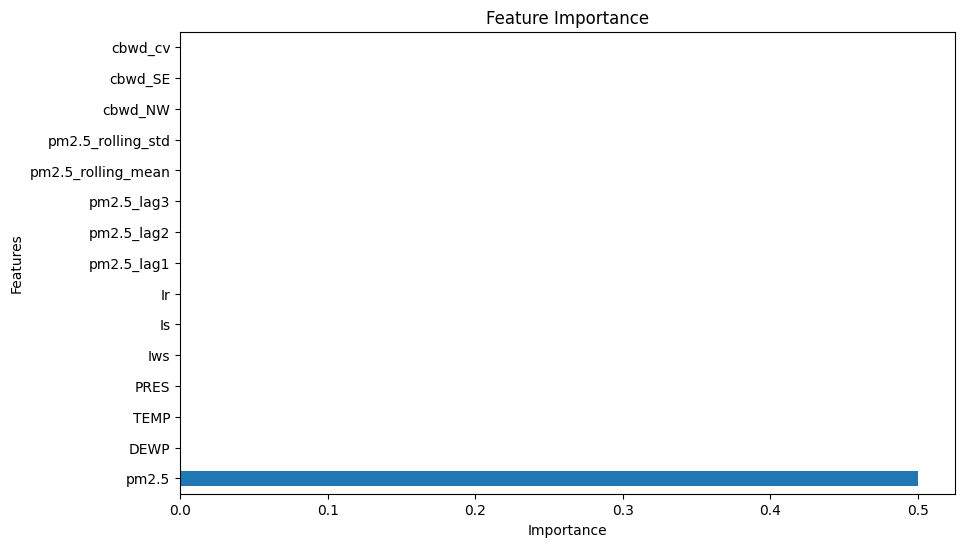

In [25]:
# Plot feature importance
classification_feature_importance[['importance']].plot(kind='barh', figsize=(10, 6), legend=False)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Saving

In [26]:
# Save the regression model
predictor.save("regression_model")

# Save the classification model
predictor_class.save("classification_model")

print("Models saved successfully.")

Models saved successfully.


# Tuning

In [27]:
# Define the hyperparameter space for AutoGluon to explore
hyperparameters = {
    'GBM': {},  # Leave empty to let AutoGluon decide the best values
    'XGB': {},
    'CAT': {},
    'XT': {},
    'NN_TORCH': {},
    'FASTAI': {}
}

# Setup hyperparameter tuning
hyperparameter_tune_kwargs = {
    'num_trials': 5,  # Number of different hyperparameter configurations to try
    'scheduler': 'local',  # Local runs (not distributed)
    'searcher': 'random',  # Random search strategy
}

# Initialize and train the predictor with hyperparameter tuning
predictor = TabularPredictor(
    label='pm2.5',
    problem_type='regression'
).fit(
    train_data,
    hyperparameters=hyperparameters,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
    time_limit=6000
)

# Evaluate the model on the test set
regression_performance = predictor.evaluate(test_data)
print("\nPerformance Metrics after Hyperparameter Tuning:")
display(regression_performance)

No path specified. Models will be saved in: "AutogluonModels/ag-20240829_221414"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          8
Memory Avail:       48.02 GB / 50.99 GB (94.2%)
Disk Space Avail:   182.16 GB / 225.83 GB (80.7%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : 

  0%|          | 0/5 [00:00<?, ?it/s]

[1000]	valid_set's rmse: 6.77181
[2000]	valid_set's rmse: 6.50763
[3000]	valid_set's rmse: 6.45044
[4000]	valid_set's rmse: 6.44028
[5000]	valid_set's rmse: 6.44355
[1000]	valid_set's rmse: 8.7997
[2000]	valid_set's rmse: 8.79519
[1000]	valid_set's rmse: 8.75186
[2000]	valid_set's rmse: 8.40061
[3000]	valid_set's rmse: 8.26751
[4000]	valid_set's rmse: 8.1842
[5000]	valid_set's rmse: 8.14627
[6000]	valid_set's rmse: 8.18629
[1000]	valid_set's rmse: 10.2518
[2000]	valid_set's rmse: 8.79302
[3000]	valid_set's rmse: 8.35674
[4000]	valid_set's rmse: 8.22615
[5000]	valid_set's rmse: 8.12734
[6000]	valid_set's rmse: 8.05232
[7000]	valid_set's rmse: 7.99275
[8000]	valid_set's rmse: 7.95149
[9000]	valid_set's rmse: 7.91864
[10000]	valid_set's rmse: 7.88722
[1000]	valid_set's rmse: 8.23991
[2000]	valid_set's rmse: 8.01031
[3000]	valid_set's rmse: 7.98991
[4000]	valid_set's rmse: 7.96428
[5000]	valid_set's rmse: 7.95703
[6000]	valid_set's rmse: 7.95003
[7000]	valid_set's rmse: 7.95248


Fitted model: LightGBM/T1 ...
	-6.4394	 = Validation score   (-root_mean_squared_error)
	7.29s	 = Training   runtime
	0.62s	 = Validation runtime
Fitted model: LightGBM/T2 ...
	-8.7948	 = Validation score   (-root_mean_squared_error)
	5.92s	 = Training   runtime
	0.35s	 = Validation runtime
Fitted model: LightGBM/T3 ...
	-8.1432	 = Validation score   (-root_mean_squared_error)
	14.41s	 = Training   runtime
	1.25s	 = Validation runtime
Fitted model: LightGBM/T4 ...
	-7.8869	 = Validation score   (-root_mean_squared_error)
	27.22s	 = Training   runtime
	4.05s	 = Validation runtime
Fitted model: LightGBM/T5 ...
	-7.9486	 = Validation score   (-root_mean_squared_error)
	15.48s	 = Training   runtime
	1.39s	 = Validation runtime
Hyperparameter tuning model: CatBoost ... Tuning model for up to 899.98s of the 5918.36s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

Fitted model: CatBoost/T1 ...
	-6.7747	 = Validation score   (-root_mean_squared_error)
	37.73s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CatBoost/T2 ...
	-6.4558	 = Validation score   (-root_mean_squared_error)
	25.14s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CatBoost/T3 ...
	-7.3598	 = Validation score   (-root_mean_squared_error)
	150.09s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: CatBoost/T4 ...
	-6.2925	 = Validation score   (-root_mean_squared_error)
	123.85s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: CatBoost/T5 ...
	-6.5697	 = Validation score   (-root_mean_squared_error)
	115.2s	 = Training   runtime
	0.01s	 = Validation runtime
Hyperparameter tuning model: ExtraTrees ... Tuning model for up to 899.98s of the 5465.64s of remaining time.
	No hyperparameter search space specified for ExtraTrees. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTr

+--------------------------------------------------------+
| Configuration for experiment     NeuralNetFastAI       |
+--------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator |
| Scheduler                        FIFOScheduler         |
| Number of trials                 5                     |
+--------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20240829_221414/models/NeuralNetFastAI


Fitted model: NeuralNetFastAI/4c371_00000 ...
	-0.9669	 = Validation score   (-root_mean_squared_error)
	46.97s	 = Training   runtime
	0.08s	 = Validation runtime
Fitted model: NeuralNetFastAI/4c371_00001 ...
	-5.6913	 = Validation score   (-root_mean_squared_error)
	126.42s	 = Training   runtime
	0.27s	 = Validation runtime
Fitted model: NeuralNetFastAI/4c371_00002 ...
	-8.6969	 = Validation score   (-root_mean_squared_error)
	13.17s	 = Training   runtime
	0.06s	 = Validation runtime
Fitted model: NeuralNetFastAI/4c371_00003 ...
	-7.0269	 = Validation score   (-root_mean_squared_error)
	36.3s	 = Training   runtime
	0.12s	 = Validation runtime
Fitted model: NeuralNetFastAI/4c371_00004 ...
	-3.1419	 = Validation score   (-root_mean_squared_error)
	25.43s	 = Training   runtime
	0.05s	 = Validation runtime
Hyperparameter tuning model: XGBoost ... Tuning model for up to 899.98s of the 5315.85s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

Fitted model: XGBoost/T1 ...
	-9.3058	 = Validation score   (-root_mean_squared_error)
	3.31s	 = Training   runtime
	0.11s	 = Validation runtime
Fitted model: XGBoost/T2 ...
	-9.3473	 = Validation score   (-root_mean_squared_error)
	3.53s	 = Training   runtime
	0.08s	 = Validation runtime
Fitted model: XGBoost/T3 ...
	-10.1469	 = Validation score   (-root_mean_squared_error)
	14.31s	 = Training   runtime
	0.81s	 = Validation runtime
Fitted model: XGBoost/T4 ...
	-8.1483	 = Validation score   (-root_mean_squared_error)
	7.4s	 = Training   runtime
	0.21s	 = Validation runtime
Fitted model: XGBoost/T5 ...
	-11.704	 = Validation score   (-root_mean_squared_error)
	17.96s	 = Training   runtime
	1.06s	 = Validation runtime
Hyperparameter tuning model: NeuralNetTorch ... Tuning model for up to 899.98s of the 5265.93s of remaining time.


+--------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch        |
+--------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator |
| Scheduler                        FIFOScheduler         |
| Number of trials                 5                     |
+--------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20240829_221414/models/NeuralNetTorch


Fitted model: NeuralNetTorch/bc24a_00000 ...
	-10.6384	 = Validation score   (-root_mean_squared_error)
	64.05s	 = Training   runtime
	0.05s	 = Validation runtime
Fitted model: NeuralNetTorch/bc24a_00001 ...
	-7.1296	 = Validation score   (-root_mean_squared_error)
	90.38s	 = Training   runtime
	0.06s	 = Validation runtime
Fitted model: NeuralNetTorch/bc24a_00002 ...
	-8.8644	 = Validation score   (-root_mean_squared_error)
	69.56s	 = Training   runtime
	0.04s	 = Validation runtime
Fitted model: NeuralNetTorch/bc24a_00003 ...
	-9.8375	 = Validation score   (-root_mean_squared_error)
	85.5s	 = Training   runtime
	0.06s	 = Validation runtime
Fitted model: NeuralNetTorch/bc24a_00004 ...
	-7.4096	 = Validation score   (-root_mean_squared_error)
	155.37s	 = Training   runtime
	0.05s	 = Validation runtime


Fitting model: WeightedEnsemble_L2 ... Training model for up to 599.98s of the 5091.41s of remaining time.
	Ensemble Weights: {'NeuralNetFastAI/4c371_00000': 0.87, 'CatBoost/T2': 0.043, 'NeuralNetFastAI/4c371_00004': 0.043, 'NeuralNetTorch/bc24a_00000': 0.043}
	-0.6544	 = Validation score   (-root_mean_squared_error)
	0.05s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 908.69s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 25312.0 rows/s (5000 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20240829_221414")



Performance Metrics after Hyperparameter Tuning:


{'root_mean_squared_error': -0.6365645118182379,
 'mean_squared_error': -0.40521437770639157,
 'mean_absolute_error': -0.41441912201646797,
 'r2': 0.9999531782206983,
 'pearsonr': 0.999977271991633,
 'median_absolute_error': -0.348177433013916}

In [28]:
# Define the hyperparameter space for AutoGluon to explore
hyperparameters = {
    'GBM': {},  # Leave empty to let AutoGluon decide the best values
    'XGB': {},
    'CAT': {},
    'XT': {},
    'NN_TORCH': {},
    'FASTAI': {}
}

# Setup hyperparameter tuning
hyperparameter_tune_kwargs = {
    'num_trials': 5,  # Number of different hyperparameter configurations to try
    'scheduler': 'local',  # Local runs (not distributed)
    'searcher': 'random',  # Random search strategy
}

# Initialize and train the predictor with hyperparameter tuning for classification
predictor_class = TabularPredictor(
    label='high_pollution',
    problem_type='binary'
).fit(
    train_data,
    hyperparameters=hyperparameters,
    time_limit=6000  # Time limit in seconds for the tuning process
)

# Evaluate the model on the test set
classification_performance = predictor_class.evaluate(test_data)
print("\nClassification Performance Metrics after Hyperparameter Tuning:")
display(classification_performance)

No path specified. Models will be saved in: "AutogluonModels/ag-20240829_222923"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          8
Memory Avail:       46.89 GB / 50.99 GB (92.0%)
Disk Space Avail:   181.25 GB / 225.83 GB (80.3%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : 


Classification Performance Metrics after Hyperparameter Tuning:


{'accuracy': 1.0,
 'balanced_accuracy': 1.0,
 'mcc': 1.0,
 'roc_auc': 1.0,
 'f1': 1.0,
 'precision': 1.0,
 'recall': 1.0}

# Leaderboard

In [29]:
# View leaderboard
regression_leaderboard = predictor.leaderboard(test_data, silent=True)
print("Regression Model Leaderboard:")
display(regression_leaderboard)

Regression Model Leaderboard:


,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.636565,-0.654442,root_mean_squared_error,0.384345,0.197535,161.636946,0.004206,0.000966,0.052339,2,True,27
1,NeuralNetFastAI/4c371_00000,-0.752824,-0.966944,root_mean_squared_error,0.257699,0.084810,46.965142,0.257699,0.084810,46.965142,1,True,12
2,NeuralNetFastAI/4c371_00004,-2.911944,-3.141851,root_mean_squared_error,0.056663,0.053371,25.427535,0.056663,0.053371,25.427535,1,True,16
3,NeuralNetFastAI/4c371_00001,-5.292424,-5.691332,root_mean_squared_error,0.595946,0.274508,126.419491,0.595946,0.274508,126.419491,1,True,13
4,LightGBM/T1,-5.309113,-6.439409,root_mean_squared_error,1.176596,0.618090,7.287645,1.176596,0.618090,7.287645,1,True,1
5,CatBoost/T2,-5.354750,-6.455834,root_mean_squared_error,0.017617,0.009011,25.137933,0.017617,0.009011,25.137933,1,True,7
6,CatBoost/T4,-5.419869,-6.292501,root_mean_squared_error,0.055391,0.020011,123.848949,0.055391,0.020011,123.848949,1,True,9
7,NeuralNetTorch/bc24a_00001,-5.505419,-7.129610,root_mean_squared_error,0.064447,0.057030,90.383106,0.064447,0.057030,90.383106,1,True,23
8,CatBoost/T1,-5.514878,-6.774733,root_mean_squared_error,0.055576,0.013920,37.733248,0.055576,0.013920,37.733248,1,True,6
9,CatBoost/T5,-5.572066,-6.569734,root_mean_squared_error,0.056130,0.013479,115.199720,0.056130,0.013479,115.199720,1,True,10


In [30]:
# View leaderboard
classification_leaderboard = predictor_class.leaderboard(test_data, silent=True)
print("Classification Model Leaderboard:")
display(classification_leaderboard)

Classification Model Leaderboard:


,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM,1.000000,1.0000,accuracy,0.002986,0.001462,0.606889,0.002986,0.001462,0.606889,1,True,1
1,CatBoost,1.000000,1.0000,accuracy,0.005031,0.002371,0.687228,0.005031,0.002371,0.687228,1,True,2
2,WeightedEnsemble_L2,1.000000,1.0000,accuracy,0.005372,0.002836,0.727759,0.002386,0.001374,0.120870,2,True,7
3,XGBoost,1.000000,1.0000,accuracy,0.012504,0.005154,0.210981,0.012504,0.005154,0.210981,1,True,5
4,NeuralNetFastAI,0.999544,0.9992,accuracy,0.152678,0.047170,43.743902,0.152678,0.047170,43.743902,1,True,4
5,NeuralNetTorch,0.997946,0.9992,accuracy,0.053563,0.024888,86.232496,0.053563,0.024888,86.232496,1,True,6
6,ExtraTrees,0.994067,0.9888,accuracy,0.245843,0.218164,1.822042,0.245843,0.218164,1.822042,1,True,3


# TS Workflow

In [31]:
from autogluon.timeseries import TimeSeriesDataFrame

# Rename 'pm2.5' column to 'target'
df.rename(columns={'pm2.5': 'target'}, inplace=True)

# Prepare data for forecasting
forecast_data = df[['target']].copy()
forecast_data['item_id'] = 'Beijing_PM2.5'  # Single time series

# Create a timestamp column
forecast_data['timestamp'] = forecast_data.index

In [32]:
# Create a TimeSeriesDataFrame
forecast_data = TimeSeriesDataFrame(forecast_data[['timestamp', 'item_id', 'target']])

# Display the data
display(forecast_data.head())

target
item_id       timestamp                  
Beijing_PM2.5 2010-01-01 05:00:00    72.0
              2010-01-01 06:00:00    72.0
              2010-01-01 07:00:00    72.0
              2010-01-01 08:00:00    72.0
              2010-01-01 09:00:00    72.0

In [33]:
# # Perform a temporal train-test split on the TimeSeriesDataFrame
# train_size = int(len(forecast_data) * 0.8)
# train_data = forecast_data.iloc[:train_size]
# test_data = forecast_data.iloc[train_size:]

# # Verify the split
# print(f"Training data range: {train_data.index.min()} to {train_data.index.max()}")
# print(f"Testing data range: {test_data.index.min()} to {test_data.index.max()}")

In [34]:
# Number of hours in the last 3 days
hours_in_last_3_days = 3 * 24 + 1  # Adding 1 to the desired forecast horizon

# Perform a temporal train-test split
train_data = forecast_data.iloc[:-hours_in_last_3_days]
test_data = forecast_data.iloc[-hours_in_last_3_days:]

# Verify the split
print(f"Training data range: {train_data.index.min()} to {train_data.index.max()}")
print(f"Testing data range: {test_data.index.min()} to {test_data.index.max()}")

Training data range: ('Beijing_PM2.5', Timestamp('2010-01-01 05:00:00')) to ('Beijing_PM2.5', Timestamp('2014-12-28 22:00:00'))
Testing data range: ('Beijing_PM2.5', Timestamp('2014-12-28 23:00:00')) to ('Beijing_PM2.5', Timestamp('2014-12-31 23:00:00'))


In [35]:
from autogluon.timeseries import TimeSeriesPredictor

# Set the prediction length
prediction_length = 3 * 24

# Initialize the predictor
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target="target",
    eval_metric="MAPE",
    verbosity=2
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240829_223201"


In [36]:
# Train the predictor
predictor.fit(
    train_data,
    presets='high_quality',
    time_limit=600
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'AutogluonModels/ag-20240829_223201'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          8
GPU Count:          0
Memory Avail:       46.80 GB / 50.99 GB (91.8%)
Disk Space Avail:   181.18 GB / 225.83 GB (80.2%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 72,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'H'
Provided train_data has 437

In [37]:
# Get predictions
predictions = predictor.predict(train_data)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2  \
item_id       timestamp                                                 
Beijing_PM2.5 2014-12-28 23:00:00  186.705010  111.958912  135.383755   
              2014-12-29 00:00:00  195.194700   92.445675  126.467462   
              2014-12-29 01:00:00  192.877701   68.134088  108.492881   
              2014-12-29 02:00:00  224.246565   81.593079  127.797605   
              2014-12-29 03:00:00  228.388493   70.714933  122.038947   

                                          0.3         0.4         0.5  \
item_id       timestamp                                                 
Beijing_PM2.5 2014-12-28 23:00:00  152.325638  169.715677  186.705010   
              2014-12-29 00:00:00  152.535695  173.932854  195.194700   
              2014-12-29 01:00:00  139.523766  168.478608  192.877701   
              2014-12-29 02:00:00  162.197499  194.913062  224.246565   
              2014-12-29 03:00:00  159.929339  197.893647  228.388493   

                                          0.6         0.7         0.8  \
item_id       timestamp                                                 
Beijing_PM2.5 2014-12-28 23:00:00  204.726600  222.374704  245.639167   
              2014-12-29 00:00:00  219.166224  243.918221  274.115487   
              2014-12-29 01:00:00  218.309053  248.167121  282.810909   
              2014-12-29 02:00:00  253.838133  293.392406  335.147138   
              2014-12-29 03:00:00  265.593015  302.396033  344.028361   

                                          0.9  
item_id       timestamp                        
Beijing_PM2.5 2014-12-28 23:00:00  287.644656  
              2014-12-29 00:00:00  320.266306  
              2014-12-29 01:00:00  334.137443  
              2014-12-29 02:00:00  388.964567  
              2014-12-29 03:00:00  406.320117

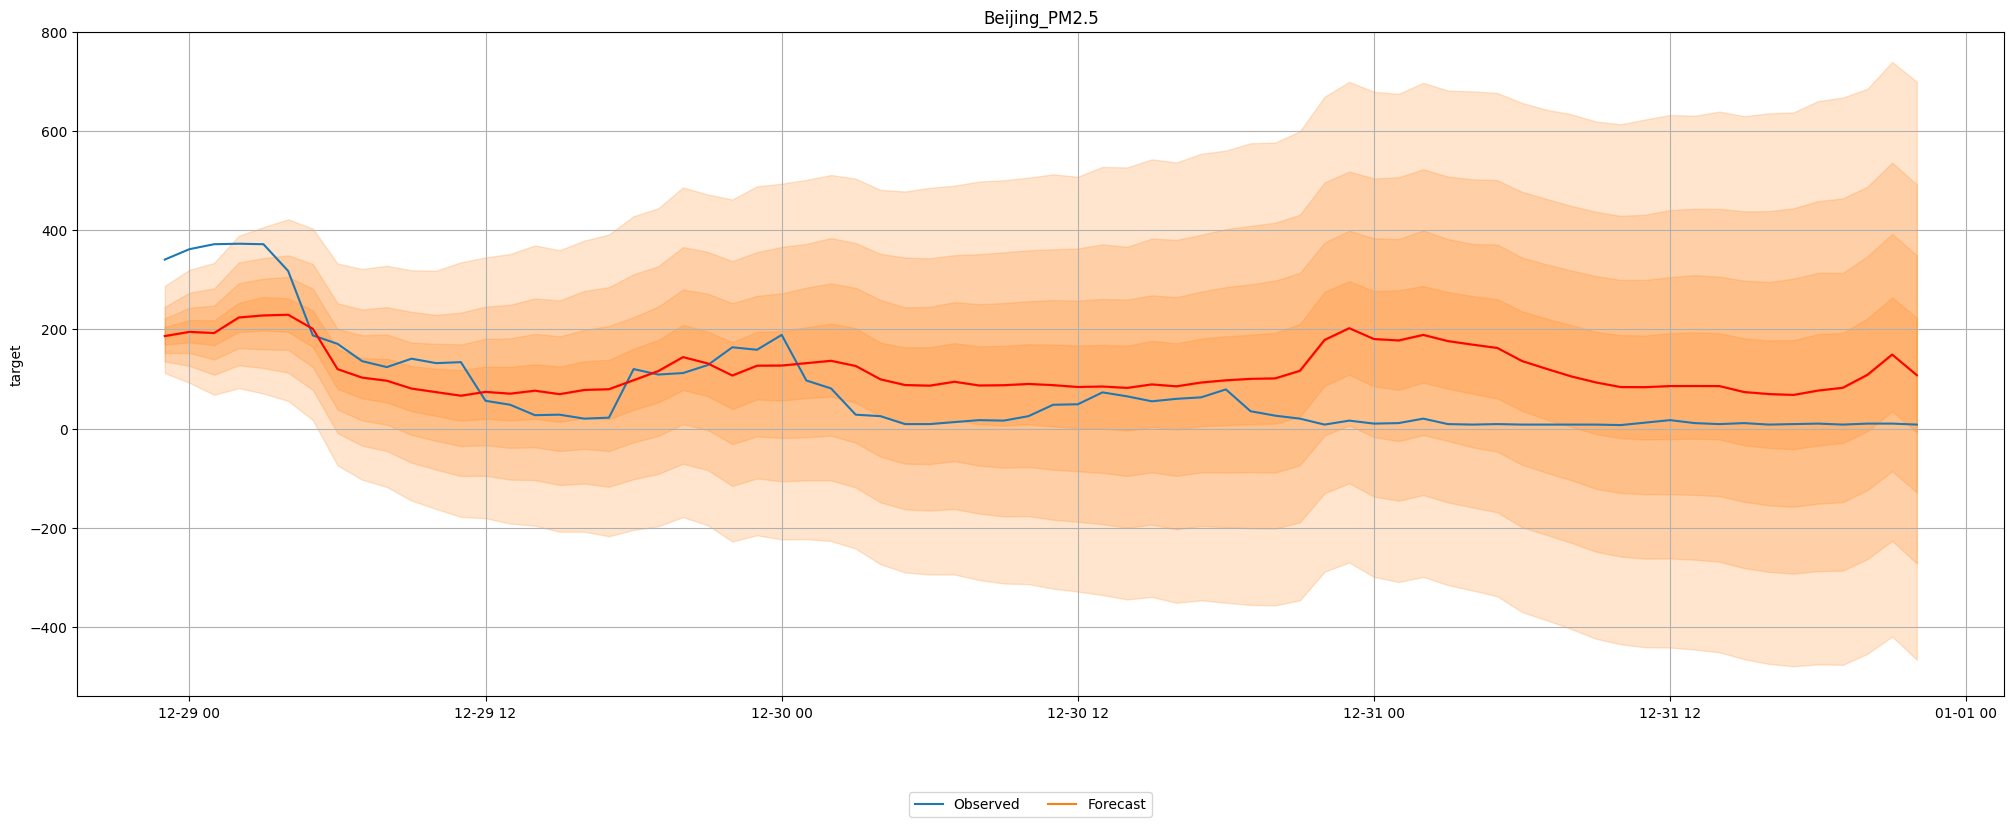

In [38]:
# Plotting the forecast and observed values
predictor.plot(
    test_data[:-1],
    predictions,
    quantile_levels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    max_history_length=prediction_length
)

# Get the current figure and axis
fig = plt.gcf()
ax = plt.gca()

# Adjust the size of the plot
fig.set_size_inches(20, 8)

# Change the forecast line color
ax.get_lines()[-1].set_color('red')

# Display the plot
plt.show()

In [39]:
import sklearn.metrics
from autogluon.timeseries.metrics import TimeSeriesScorer

class MQL(TimeSeriesScorer):
   needs_quantile = True
   greater_is_better_internal = False
   optimum = 0.0

   def compute_metric(self, data_future, predictions, target, **kwargs):
      quantile_columns = [col for col in predictions if col != "mean"]
      total_quantile_loss = 0.0
      for q in quantile_columns:
        total_quantile_loss += sklearn.metrics.mean_pinball_loss(y_true=data_future[target], y_pred=predictions[q], alpha=float(q))
      return total_quantile_loss / len(quantile_columns)

In [40]:
from autogluon.timeseries.metrics import MAE, MSE, RMSE, WAPE, MAPE, SMAPE

# Initialize the custom metric (Mean Quantile Loss)
mean_quantile_loss = MQL()

# Evaluate the model with specified metrics including the custom metric
evaluation_results = predictor.evaluate(
    test_data,
    metrics=[MAE(), MSE(), RMSE(), WAPE(), MAPE(), SMAPE(), mean_quantile_loss]
)

# Convert the evaluation results into a DataFrame
evaluation_df = pd.DataFrame(evaluation_results.items(), columns=['Metric', 'Score'])

# Display the DataFrame
print("\nEvaluation Results DataFrame:")
display(evaluation_df)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble



Evaluation Results DataFrame:


,Metric,Score
0,MAE,-272.486111
1,MSE,-81375.180556
2,RMSE,-285.263353
3,WAPE,-3.799923
4,MAPE,-17.262056
5,SMAPE,-1.441960
6,MQL,-136.243056
